Importation des bibliothèques

In [ ]:
import os
import sys # Permet d'ajouter le dossier parent aux chemins d'import
sys.path.append("..")

In [ ]:
from osgeo import gdal
import geopandas as gpd

import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np


Importation des bibliothèques personnelles

In [ ]:
from libsigma import read_and_write as rw

## Nombre de polygones par classe
==> diag_baton_nb_pix_by_class.png

In [ ]:
strates_bretagne = '/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp'
gdf = gpd.read_file(strates_bretagne)
gdf.head()

,id,strate,comment,geometry
0,1,3,lande basse,"POLYGON ((441224.58 5366298.317, 441224.779 53..."
1,2,3,lande basse,"POLYGON ((441649.972 5366251.139, 441650.172 5..."
2,3,3,lande basse,"POLYGON ((441383.597 5366193.034, 441384.395 5..."
3,4,2,None,"POLYGON ((441336.658 5366402.088, 441337.257 5..."
4,5,2,None,"POLYGON ((441062.121 5366343.165, 441062.919 5..."


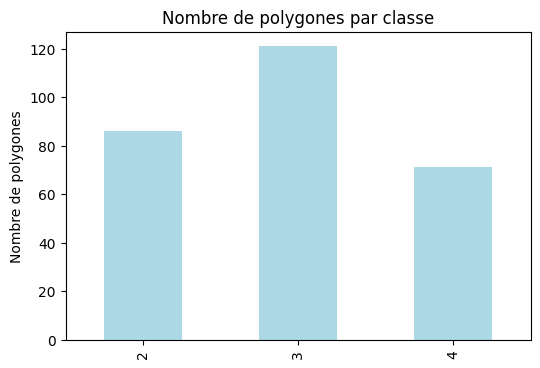

In [ ]:
label_classes = 'strate'
poly_count = gdf[label_classes].value_counts().sort_index()

plt.figure(figsize=(6,4))
poly_count.plot(kind="bar", color="lightblue")
plt.xlabel("")
plt.ylabel("Nombre de polygones")
plt.title("Nombre de polygones par classe")
plt.savefig("/home/onyxia/work/results/figure/diag_baton_nb_poly_by_class.png", dpi=300)


## Nombre de pixel par classe
==> diag_baton_nb_pix_by_class.png

In [ ]:
filename = '/home/onyxia/work/data/projet_eval/bretagne_24-25_B02.tif'
data_set = gdal.Open(filename, gdal.GA_ReadOnly)

/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [ ]:
print('Number of columns :', data_set.RasterXSize)
print('Number of lines :', data_set.RasterYSize)
print('Number of bands :', data_set.RasterCount)

Number of columns : 1533
Number of lines : 612
Number of bands : 6


In [ ]:
i = 3
raster_band = data_set.GetRasterBand(i)
print("Nodata : ", raster_band.GetNoDataValue())
print("Description : ", raster_band.GetDescription())

Nodata :  None
Description :  stackstac-a1f147bb8900a423c05701d4044aa41e


On cherche à avoir un raster par date, qui contient toutes les bandes correspondantes.
1 date = 1 raster = 10 bandes

In [ ]:
base_path = "/home/onyxia/work/data/projet_eval/"
bands = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]
dates = ["2025-03-31","2025-04-10","2025-05-15","2025-06-17","2025-07-12","2025-08-10"]

for band in bands:
    filename = os.path.join(base_path, f"bretagne_24-25_{band}.tif")
    arr = rw.load_img_as_array(filename)  # shape = (lignes, colonnes, nb_dates)
    nb_dates = arr.shape[2]

    for i in range(nb_dates):
        out_filename = os.path.join(base_path, f"{band}_{dates[i]}.tif")
        # on récupère la bande i (pour la date i)
        single_band = arr[:, :, i]
        # reshape pour que write_image fonctionne correctement (3D)
        single_band_3d = np.atleast_3d(single_band)
        rw.write_image(out_filename, single_band_3d, data_set=rw.open_image(filename))
        print(f"Fichier écrit : {out_filename}")

Le problème c'est que ça ne compile pas toutes les bandes ...

base_path = "/home/onyxia/work/results/"
bands = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]
dates = ["2025-03-31","2025-04-10","2025-05-15","2025-06-17","2025-07-12","2025-08-10"]

for i, date in enumerate(dates):
    band_arrays = []
    
    # Extraction des bandes de date
    for band in bands:
        filename = os.path.join(base_path, f"bretagne_24-25_{band}.tif")
        arr = rw.load_img_as_array(filename)
        # extraire la bande correspondant à la date i
        single_band = arr[:, :, i]
        # s'assurer que c'est 3D pour write_image
        band_arrays.append(np.atleast_3d(single_band))
    
    # Concaténer toutes les bandes pour cette date
    all_bands = np.dstack(band_arrays)
    
    out_filename = os.path.join(base_path, f"bretagne_{date}.tif")
    rw.write_image(out_filename, all_bands, data_set=rw.open_image(os.path.join(base_path, f"bretagne_24-25_{bands[0]}.tif")))
    print(f"Fichier créé pour {date} -> {out_filename}")